<a href="https://colab.research.google.com/github/BaDybala/Computational-Physics-Projects/blob/main/Linear%20and%20Nonlinear%20Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple fitting examples

In this notebook, we will see how to fit simple models, both linear and non linear

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
rng = np.random.default_rng(seed=1234)
x = rng.uniform(-10,10,20)
s = rng.uniform(0.1,1.0,len(x))
e_ = rng.normal(0,1,len(x))
e = e_ * s
xx = np.linspace(-10,10,100)

# Polynomial fit

In [ ]:
# simulate data with a quadratic model [edit to try a lower or higher order]
p_true = [-0.05,0.23,3.0] # highest order first
# generate noisy data
y_obs = np.polyval(p_true, x) + e
# true function (for plotting)
yy_true = np.polyval(p_true, xx)


P[0]: true = -0.0500, fitted = -0.0535 +/- 0.0020
P[1]: true = 0.2300, fitted = 0.2534 +/- 0.0102
P[2]: true = 3.0000, fitted = 3.0728 +/- 0.0964


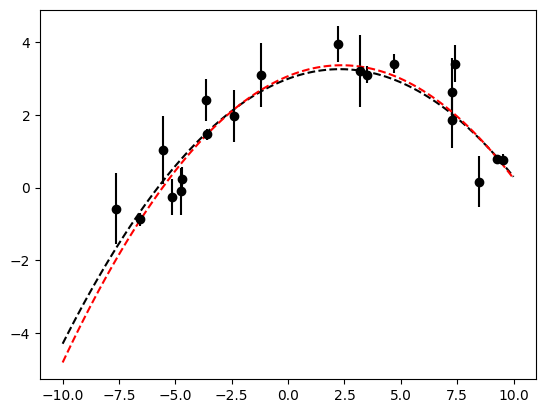

In [ ]:
p_fit, cov = np.polyfit(x, y_obs, len(p_true)-1,
                        w = 1/s**2, # this accounts for the varying uncertainties
                        cov=True)
e_fit = np.sqrt(np.diag(cov)) # this is the array of standard parameter errors
for i in range(len(p_true)):
  print('P[{}]: true = {:.4f}, fitted = {:.4f} +/- {:.4f}'.format(i, p_true[i], p_fit[i], e_fit[i]))
yy_fit = np.polyval(p_fit, xx)
plt.errorbar(x, y_obs, yerr = s, fmt = 'ko')
plt.plot(xx, yy_true, 'k--')
plt.plot(xx, yy_fit, 'r--');

# Linear least squares

In [ ]:
# simulate data with a quadratic model
p_true = [-0.05,0.23,3.0] # highest order first
# construct matrix of polynomial basis functions
def poly_design_matrix(m,x):
  A = np.zeros((m, len(x)))
  for j in range(m):
    A[-j-1] = x**j
  return A
# generate noisy data
A_obs = poly_design_matrix(len(p_true), x)
y_obs = np.dot(p_true, A_obs) + e
# true function (for plotting)
A_xx = poly_design_matrix(len(p_true), xx)
yy_true = np.dot(p_true, A_xx)

P[0]: true = -0.0500, fitted = -0.0515
P[1]: true = 0.2300, fitted = 0.2356
P[2]: true = 3.0000, fitted = 3.1717


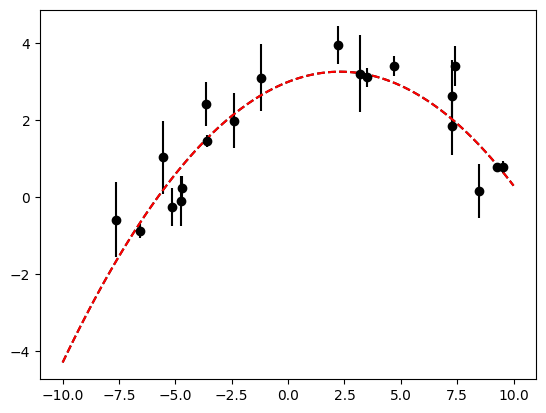

In [ ]:
res = np.linalg.lstsq(A_obs.T, y_obs, rcond = None)
p_fit = res[0]
for i in range(len(p_true)):
  print('P[{}]: true = {:.4f}, fitted = {:.4f}'.format(i, p_true[i], p_fit[i]))
yy_fit = np.dot(p_true, A_xx)
plt.errorbar(x, y_obs, yerr = s, fmt = 'ko')
plt.plot(xx, yy_true, 'k--')
plt.plot(xx, yy_fit, 'r--');

## Non-linear model


In [ ]:
# instead of a polynomial let's simulate data with a Gaussian
# parameters are now amplitude, mean and standard deviation
p_true = [11.1, -1.0, 5.5]
def gauss(p, x):
  return p[0] * np.exp(-(x-p[1])**2/p[2])
# generate noisy data
y_obs = gauss(p_true, x) + e
# true function (for plotting)
yy_true = gauss(p_true, xx)

We will use the `minimize` function from `scipy.optimize`. This needs a user-defined function that evaluates the quantity to minimize - in our case the $\chi^2$ of the fit.

We also need an initial guess for the parameters.

Optimization terminated successfully.
P[0]: true = 11.1000, fitted = 11.9579 +/- 0.5558
P[1]: true = -1.0000, fitted = -0.8864 +/- 0.0622
P[2]: true = 5.5000, fitted = 5.5357 +/- 0.2494


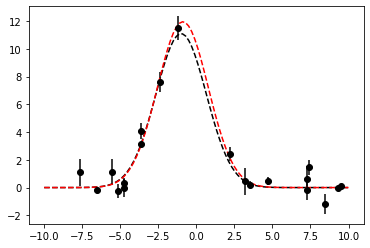

In [ ]:
from scipy.optimize import minimize
def chi2(p, func, x, y, e_y):
  m = func(p,x)
  r = (y-m)/e_y
  return (r**2).sum()
p0 = p_true + rng.uniform(-1,1,len(p_true)) # start a little away from true value
soln = minimize(chi2, p0, (gauss,x, y_obs, s))
print(soln.message)
p_fit = soln.x # this is the array of best-fit parameters
e_fit = np.sqrt(np.diag(soln.hess_inv)) # this is the array of standard parameter errors
for i in range(len(p_true)):
  print('P[{}]: true = {:.4f}, fitted = {:.4f} +/- {:.4f}'.format(i, p_true[i], p_fit[i], e_fit[i]))
yy_fit = gauss(p_fit, xx)
plt.errorbar(x, y_obs, yerr = s, fmt = 'ko')
plt.plot(xx, yy_true, 'k--')
plt.plot(xx, yy_fit, 'r--');


## Unknown systematics

What if our observations were affected by an additional source of systematic error that adds in quadrature to all the individual observations' variances?

In [ ]:
s_add = 0.5
s_new = np.sqrt(s**2 + s_add**2)
e = e_ * s_new
y_obs = gauss(p_true, x) + e

Optimization terminated successfully.
P[0]: true = 11.1000, fitted = 12.0509 +/- 1.0962
P[1]: true = -1.0000, fitted = -0.8103 +/- 0.1720
P[2]: true = 5.5000, fitted = 5.6753 +/- 0.6699
P[3]: true = 0.5000, fitted = -0.3940 +/- 1.0000
P[4]: true = 0.5000, fitted = 0.6793 +/- 0.1699


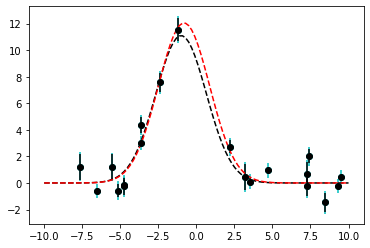

In [ ]:
def nll(p, func, x, y, e_y):
  e_new = np.sqrt(e_y**2 + p[-1]**2)
  m = func(p[:-1],x)
  r = (y-m)/e_new
  nll = 0.5 * (r**2).sum() + np.log(e_new).sum()
  return nll
p_true_new = np.append(p_true, s_add)
p0 = p_true_new + rng.uniform(-1,1,len(p_true_new)) # start a little away from true value
soln = minimize(nll, p0, (gauss,x, y_obs, s))
print(soln.message)
p_fit = soln.x # this is the array of best-fit parameters
e_fit = np.sqrt(np.diag(soln.hess_inv)) # this is the array of standard parameter errors
for i in range(len(p_true_new)):
  print('P[{}]: true = {:.4f}, fitted = {:.4f} +/- {:.4f}'.format(i, p_true_new[i], p_fit[i], e_fit[i]))
yy_fit = gauss(p_fit[:-1], xx)
plt.errorbar(x, y_obs, yerr = np.sqrt(s**2 + s_add**2), fmt = 'co')
plt.errorbar(x, y_obs, yerr = s, fmt = 'ko')
plt.plot(xx, yy_true, 'k--')
plt.plot(xx, yy_fit, 'r--');
